In [1]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data

import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean

data_dir = '../../../data/'

### Load the data

In [6]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])


sal_temp_ph = data[
  (data['SAL (PSU)'].notnull())
  & (data['pH ()'].notnull())
  & (data['TEMP (C)'].notnull())
  & (data['VAL_QUAL'] != -1)
  ]

# Remove HAR station

# Station N18 will be used for validation
station = 'N18'
n18 = sal_temp_ph[sal_temp_ph['STAT_ID'] == station]
sal_temp_ph = sal_temp_ph[sal_temp_ph['STAT_ID'] != station]

len(sal_temp_ph)

2669

### Gaussian Process Regression

In [7]:
SAL = sal_temp_ph['SAL (PSU)'].values.reshape(-1, 1)
TEMP = sal_temp_ph['TEMP (C)'].values.reshape(-1, 1)

X = np.concatenate((SAL, TEMP), axis=1)

Y = sal_temp_ph['pH ()'].values

In [8]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

print(train_x.shape)
print(train_y.shape)

torch.Size([2669, 2])
torch.Size([2669])


In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [36]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [37]:
# If a gpu is available, use it
print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    train_x = train_x.cuda()
    train_y = train_y.cuda()

False


In [38]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [51]:
training_iter = 1

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.sum().backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/1 - Loss: 0.025   lengthscale: 1.430   noise: 0.117


In [14]:
# Load trained model from memory
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model.load_state_dict(torch.load('../models/pH_0.117Loss.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [52]:
SAL = np.linspace(n18['SAL (PSU)'].min(), n18['SAL (PSU)'].max(), 100)
TEMP = np.linspace(n18['TEMP (C)'].min(), n18['TEMP (C)'].max(), 100)

X1, X2 = np.meshgrid(SAL, TEMP)

X = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)

In [53]:
model.cpu()
likelihood.cpu()

model.eval()
likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.from_numpy(X).float()))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

mean = mean.reshape(100, 100)
lower = lower.reshape(100, 100)
upper = upper.reshape(100, 100)

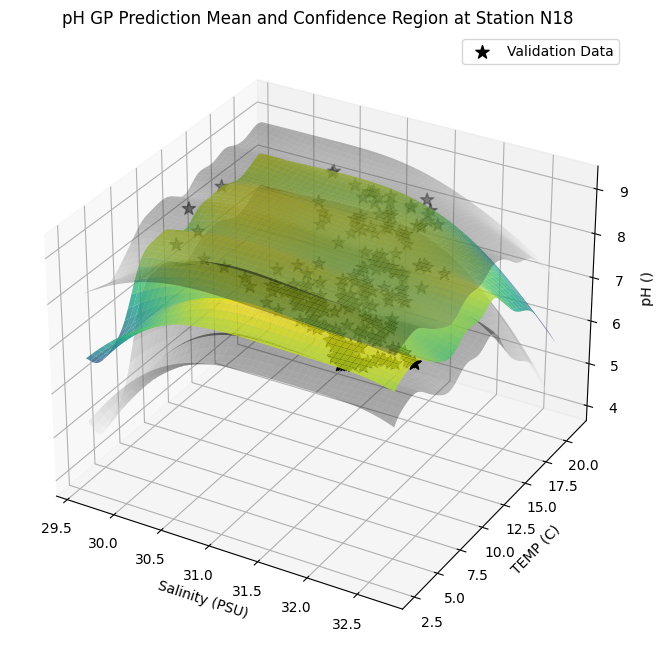

In [61]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1, X2, mean, cmap='viridis', edgecolor='none', alpha = 0.8)

ax.plot_surface(X1, X2, upper, cmap='Greys', edgecolor='none', alpha=0.35)

ax.plot_surface(X1, X2, lower, cmap='Greys', edgecolor='none',  alpha=0.35)

# Plot the observed data as stars
ax.scatter(n18['SAL (PSU)'], n18['TEMP (C)'], n18['pH ()'], marker='*', color='black', s=100, label='Validation Data')

ax.set_xlabel('Salinity (PSU)')
ax.set_ylabel('TEMP (C)')
ax.set_zlabel('pH ()')
ax.title.set_text('pH GP Prediction Mean and Confidence Region at Station N18')

ax.legend()
plt.show()

In [34]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(n18[['SAL (PSU)', 'TEMP (C)']].values).float()
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()
mean = mean.numpy()
lower = lower.numpy()
upper = upper.numpy()

In [55]:
# Find outliers
outliers = n18[(n18['pH ()'] < lower) | (n18['pH ()'] > upper)]

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'Tensor'

In [36]:
outliers

,STUDY_ID,EVENT_ID,STAT_ID,ORDERED_DEPTH_CODE,SAMPLE_ID,SAMPLE_DEPTH_TOP,SAMPLE_DEPTH_BOTTOM,LATITUDE,LONGITUDE,PROF_DATE_TIME_LOCAL,...,Sampled Bottle Name,Sampling Date,Sampling Depth,Salinity - Carolina,Salinity - Ries,Run T,Sampling T,Pressure,Comments,Data Source
3740,BWQM,WN221,N18,D,WN221076,14.78,15.78,42.366398,-70.776817,2022-02-10 10:19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRA_MassBay_upcast_2017-202205
3741,BWQM,WN221,N18,E,WN221075,19.35,20.35,42.366211,-70.776901,2022-02-10 10:19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRA_MassBay_upcast_2017-202205
3742,BWQM,WN221,N18,C,WN221077,10.14,11.14,42.366760,-70.776611,2022-02-10 10:19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRA_MassBay_upcast_2017-202205
3743,BWQM,WN221,N18,A,WN221079,0.70,1.70,42.367180,-70.776367,2022-02-10 10:19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRA_MassBay_upcast_2017-202205
3744,BWQM,WN221,N18,B,WN221078,5.33,6.33,42.367020,-70.776474,2022-02-10 10:19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRA_MassBay_upcast_2017-202205
